A problem I have frequently run into in astronomical data analysis is the need to infer parameters of a density model in which some aspects of the model are allowed to be flexible and other components are held more rigid (i.e. with a parametrized model). In these contexts, we are sometimes also interested in learning a flexible representation of the expected number or number density of objects along with a probability density function. This post demonstrates how to implement density models with flexibility controlled by spline interpolation of function values in [JAX](https://jax.readthedocs.io/en/latest/).

One example of the need for flexibility in density modeling is the classic Galactic astronomy problem of measuring the vertical stellar density profile (and midplane density) of the Galactic disk: In this problem, we start with observations of stellar positions $(x, y, z)$ (probably observed under some selection function, but we will ignore selection effects in this post) and we want to infer the midplane density value and a model for the density profile away from the midplane. Historically, parametric density profiles have been used (e.g., [Bovy et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.470.1360B/abstract)), but we now know that there are significant asymmetries in the density of stars (e.g., [Bennett et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1417B/abstract)), and so we might now want to fit a parametric density profile plus a model component to handle these deviations from symmetry.

Another problem where the need to fit models with parametric and flexible components arises is in modeling the phase-space density of stellar streams (e.g., [Koposov et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.485.4726K/abstract), [Tavangar et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...925..118T/abstract)). In the case of stellar streams, we generally want to simultaneously fit the "track" or ridgeline of the stream in position and velocity components, the width of the stream, the density along the stream, and a flexible model for the background stellar density in these components.

There are many possible options for adding flexibility to models (see: Machine Learning). One particularly useful tool that is used heavily in time series analysis are [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process) (GPs). GPs allow adding controlled flexibility in probabilistic models (i.e. weakly parametric, through specification of a kernel function) and have gained popularity in astronomy recently thanks to advances in computational efficiency in computing GP likelihoods (e.g., [celerite](https://github.com/exoplanet-dev/celerite2) or [tinygp](https://github.com/dfm/tinygp)). I won't go over GPs in this post, but there are many resources available online and on GitHub that give great introductions to GPs (e.g., [Dan Foreman-Mackey's slides](https://speakerdeck.com/dfm/an-astronomers-introduction-to-gaussian-processes-v2) or [Rodrigo Luger's tutorial](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/main/Sessions/Session13/Day2/answers/01-Introduction-to-GPs.ipynb)).

In this post, we will use another frequently-used tool for specifying flexible models: [cubic splines](https://en.wikipedia.org/wiki/Spline_(mathematics)).

In [1]:
# Some global imports we will need throughout this post:
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

# This ensures that JAX runs with 64-bit float precision by default:
from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

%matplotlib inline
import numpy as np

## Spline models

A spline function is fully determined by the degree of the polynomial used, the location of $M$ "knots" $x_m$, and the function value at the knots $f_m$. A common choice for the polynomial degree is 3, or cubic splines. 

In [2]:
import scipy.interpolate as sci

In [3]:
rng = np.random.default_rng(seed=42)

M = 8
x_m = np.linspace(0, 10, M)
f_m = rng.uniform(-1, 1, M)
spl = sci.InterpolatedUnivariateSpline(x_m, f_m, k=3)  # k = the polynomial degree

Text(0, 0.5, '$f$')

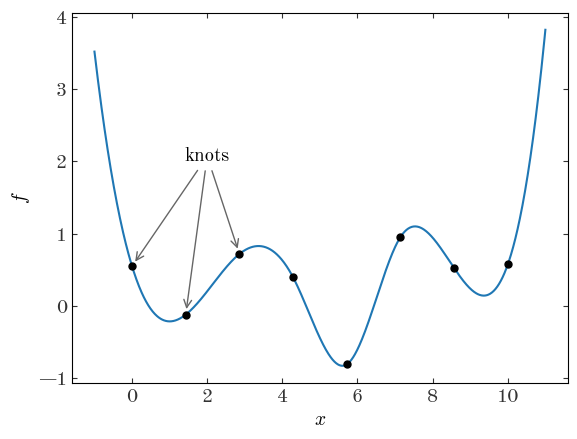

In [4]:
plt.scatter(x_m, f_m)

grid = np.linspace(-1, 11, 1024)
plt.plot(grid, spl(grid), marker="", linestyle="-", color="tab:blue", zorder=-10)

plt.annotate(
    "knots",
    xy=(x_m[0], f_m[0]),
    xytext=(2, 2),
    arrowprops=dict(color="#666", shrinkB=4, arrowstyle="->"),
    ha="center",
)
for m in range(1, 3):
    plt.annotate(
        "     ",
        xy=(x_m[m], f_m[m]),
        xytext=(2, 2),
        arrowprops=dict(color="#666", shrinkB=4, arrowstyle="->"),
        ha="center",
    )

plt.xlabel("$x$")
plt.ylabel("$f$")

The task of finding a spline representation of a function given samples or points is sometimes called "spline regression." The problem is straightforward if we pick and fix locations for the knots of the spline function we want to fit and then add into our model the values of the function at the locations of the knots. This type of model has the advantage that the (spatial) scale of flexibility or "degrees of freedom" is controllable by setting the number of knots. However, unlike in GPs where kernel functions can be used to parametrize the amplitude or spatial scales of your problem, these things are not explicitly controlled in a spline model. One other disadvantage of a spline model is that the number of parameters in your model grows as you increase the number of knots (i.e. the degrees of freedom) of the model -- this can make spline models intractable in some simple optimization routines (e.g., using `scipy.minimize` without gradient information) or in some Markov Chain Monte Carlo (MCMC) methods that do not use gradient information (e.g., Metropolis-Hastings or [`emcee`](https://emcee.readthedocs.io/en/stable/)).

Fortunately, it is possible to use spline models with [JAX](https://jax.readthedocs.io/), which automatically gives us access to functional gradients and therefore opens up the possibility of using optimization and sampling methods that perform well with large numbers of parameters. Below are two examples that demonstrate how to implement spline components in density models using JAX, to optimize the parameters of the models with [`jaxopt`](https://jaxopt.github.io/), and to generate posterior samples using Hamiltonian Monte Carlo with [`blackjax`](https://blackjax-devs.github.io/blackjax/).

## Example: Fitting a 1D density profile with splines

As a first demonstration of the idea, we are going to use simulated data to mock up a simpler version of the vertical density problem mentioned above. We will generate simulated data from a Gaussian, and then show how to fit the density distribution by modeling the points as an [inhomogeneous Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process#Inhomogeneous_Poisson_point_process) with either (1) a Gaussian or (2) a cubic spline density function. In either case, given a density function $n(z)$ (Gaussian or spline), our likelihood and log-likelihood are given by the Poisson process likelihood, given all $N$ of our $z_n$ data points:
$$
\begin{align}
p(\left\{z_n\right\}_N \,|\, n(z)) &=
    \exp{\left[-\int {\rm d}z \, n(z)\right]} \, \prod_n^N n(z_n)
\end{align}
$$

### Case 1: Gaussian model

For our first demo, we will use a Gaussian to fit the data (which were generated by a Gaussian, so this is truly a toy example). In this case:
$$
\begin{align}
n(z \,|\, N_0, \mu, \sigma) &= N_0 \, \mathcal{N}(z \,|\, \mu, \sigma)\\
\mathcal{N}(x \,|\, \mu, \sigma) &= \frac{1}{\sqrt{2\pi\,\sigma^2}} \, e^{-\,\frac{(x - \mu)^2}{2\,\sigma^2}}\\
\end{align}
$$
where $\mathcal{N}$ represents the normal distribution, $N_0$ is the total number of sources, and the mean $\mu$ and standard deviation $\sigma$ are the usual Gaussian parameters. 

The integral that appears in the first term of the Poisson process likelihood above is therefore just the total number $N_0$, as the integral over the normal distribution $\mathcal{N}$ is 1:
$$
\begin{align}
    p(\left\{z_n\right\}_N \,|\, N_0, \mu, \sigma) &= \exp{\left[-N_0 \, \int {\rm d}z \, \mathcal{N}(z)\right]}  \, \prod_n^N n(z_n)\\
    &= e^{-n_0}  \, N_0^N \, \prod_n^N \mathcal{N}(z_n \,|\, \mu, \sigma)\\
\end{align}
$$

The log-likelihood is therefore (where $N$ is the number of data points, and $N_0$ is a parameter):
$$
\begin{align}
\ln p(\left\{z_n\right\}_N \,|\, n_0, \mu, \sigma) &=
    -N_0 + N\,\ln N_0 + \sum_n^N \ln \mathcal{N}(z_n \,|\, \mu, \sigma)
\end{align}
$$

To start with, we will generate some random, normal distributed points with arbitrarily chosen mean and variance:

In [5]:
rng = np.random.default_rng(seed=42)

N = 100_000
z = rng.normal(0.03, 0.31, size=N)

# Pack the data into a dictionary so later we can store other metadata. For
# reasons that will be clear later, we also store the number of data points
# in this dictionary data structure:
data = {"N": N, "z": z}

Let's start by making a histogram of the "data" to visualize it:

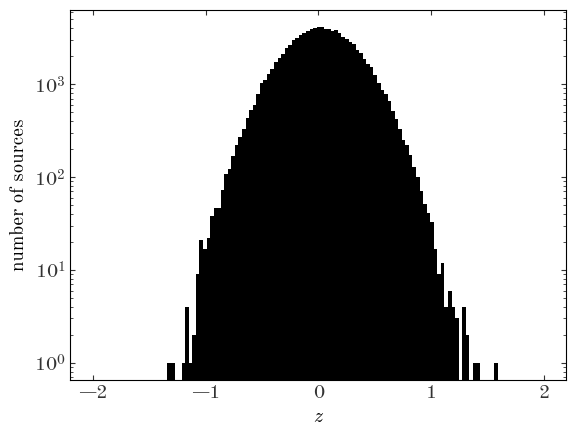

In [6]:
z_bins = np.linspace(-2, 2, 128)
plt.hist(data["z"], bins=z_bins)
plt.yscale("log")
plt.xlabel("$z$")
plt.ylabel("number of sources");

To visualize an estimate of the density function, we can use the `numpy.histogram` function instead to compute the number counts per bin and divide by the size of each bin:

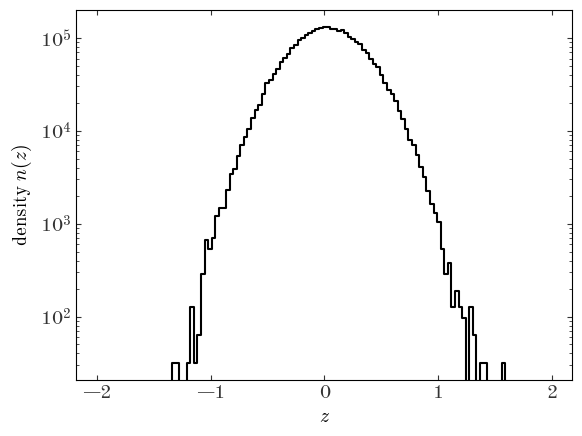

In [7]:
H, xe = np.histogram(data["z"], bins=z_bins)
xc = 0.5 * (xe[:-1] + xe[1:])
dens = H / (xe[1] - xe[0])

plt.plot(xc, dens, drawstyle="steps-mid", marker="")
plt.yscale("log")

plt.xlabel("$z$")
plt.ylabel("density $n(z)$");

In what follows, we are going to be defining several different density models and objective functions for our different density models. But ultimately, with all of these choices (e.g., Gaussian density model vs. cubic spline), we will need to be able to compute the log-likelihood given a choice of parameters. I like to use object-oriented programming (OOP) to structure my code when I am in situations like this because it helps to reduce duplicated code, enables encapsulation and namespacing, and, frankly, because I think the benefits of Python shine when using OOP. However, JAX is really designed to be used within a [*functional programming*](https://en.wikipedia.org/wiki/Functional_programming) context because of the way [Just-in-time](https://en.wikipedia.org/wiki/Just-in-time_compilation) (JIT) compilation works. You can read a bit more about this in the [JAX Gotchas](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) page, but the bottom line is that all JIT-compiled functions must be *pure functions* (functions that return the same values given the same input arguments). 

There are some advanced ways of implementing more OOP-like code with JAX, but here I'm going to (ab)use Python classes as a simple way of creating namespaces for the functions we will need with a light form of inheritance that still obeys the *pure function* requirement of JAX. These classes don't look like true OOP because we use `@classmethod`'s instead of regular instance methods, but some other OOP ideas still translate. We will start by defining a base `Model` class that implements some common methods we will need for any of the density models we implement:

In [8]:
# We will need to wrap JAX's jit function with a partial function call to get
# it to work with our classmethod's below. We will use it to tell JAX to treat
# the 0'th input (i.e. the class itself in a classmethod) as a compile-time
# constant-valued object:
from functools import partial


class Model:
    # This will store the parameter names and expected sizes of the parameters
    # (to allow for array-valued parameters) for the density models we
    # implement later on:
    param_names = {}

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def unpack_pars(cls, p_arr):
        """
        This function takes a parameter array and unpacks it into a dictionary
        with the parameter names as keys.
        """
        p_dict = {}
        j = 0
        for name, size in cls.param_names.items():
            p_dict[name] = jnp.squeeze(p_arr[j : j + size])
            j += size
        return p_dict

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def pack_pars(cls, p_dict):
        """
        This function takes a parameter dictionary and packs it into a JAX array
        where the order is set by the parameter name list defined on the class.
        """
        p_arrs = []
        for name in cls.param_names.keys():
            p_arrs.append(jnp.atleast_1d(p_dict[name]))
        return jnp.concatenate(p_arrs)

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_posterior(cls, pars_arr, data, *args):
        pars = cls.unpack_pars(pars_arr)
        return cls.ln_likelihood(pars, data, *args) + cls.ln_prior(pars)

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def objective(cls, pars_arr, N, data, *args):
        """
        This function computes an objective function to be *minimized*: In our
        case, we will be doing Bayesian statistics, so this is generally the
        negative log-posterior-probability value such that if we minimize the
        objective function, we obtain the maximum a posteriori (MAP) parameter
        values. Here we also normalize the value by the number of data points so
        that scipy's minimizers don't run into overflow issues with the
        gradients.
        """
        return -cls.ln_posterior(pars_arr, data, *args) / N

With our base `Model` class defined, we can now implement a subclass for the first model we are going to fit to our simulated data: a Gaussian! Using the true density model to fit the simulated data we should recover the input parameters that we used to generate the data:

In [9]:
def ln_normal(x, mu, var):
    """Evaluate the log-normal probability"""
    return -0.5 * (jnp.log(2 * np.pi * var) + (x - mu) ** 2 / var)

In [10]:
class GaussianModel(Model):
    param_names = {
        "ln_N0": 1,  # the log number density
        "mean": 1,  # the mean of the Gaussian
        "ln_std": 1,  # the log standard deviation
    }

    @staticmethod
    @jax.jit
    def ln_density(x, ln_N0, mean, ln_std):
        """
        This function implements the log-density of our model. Here, this is the
        log-Gaussian.
        """
        var = jnp.exp(2 * ln_std)
        return ln_N0 + ln_normal(x, mean, jnp.exp(2 * ln_std))

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_likelihood(cls, pars, data):
        """
        Implementation of the log-likelihood for an inhomogeneous Poisson
        process with underlying density (rate) function given by a Gaussian.
        Here the integral over our density function is has a simple closed form
        solution (see the math above).
        """
        dens = cls.ln_density(data["z"], **pars)
        return -jnp.exp(pars["ln_N0"]) + dens.sum()

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_prior(cls, pars):
        """
        A very light prior on the parameters. We again use Normal's for priors,
        but for most parameters we use relatively wide (large variance) values
        so that the prior does not have much of an influence.
        """
        lp = 0.0

        # A very wide, basically unconstrained Gaussian
        lp += ln_normal(pars["ln_N0"], 0, 100)

        # We expect the mean to be close to 0
        lp += ln_normal(pars["mean"], 0, 1)

        # We expect the standard deviation to be small:
        lp += ln_normal(pars["ln_std"], -2, 3)

        return lp

Let's pick some initial values for our parameters and plot the density function corresponding to our parameter choices:

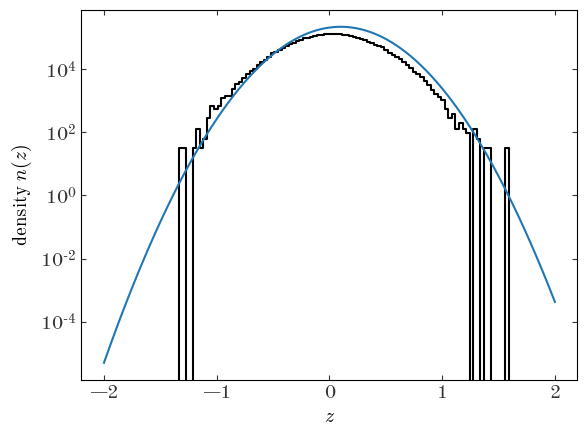

In [11]:
plt.plot(xc, dens, drawstyle="steps-mid", marker="")

init_pars = {"ln_N0": np.log(N) + 0.5, "mean": 1e-1, "ln_std": np.log(0.3)}
init_p = GaussianModel.pack_pars(init_pars)

z_grid = np.linspace(z_bins.min(), z_bins.max(), 1024)
plt.plot(z_grid, np.exp(GaussianModel.ln_density(z_grid, **init_pars)), marker="")

plt.yscale("log")

plt.xlabel("$z$")
plt.ylabel("density $n(z)$");

Those initial parameter values don't look like a very good match to the observed density, but it's probably close enough that an optimizer will be able to find a better solution from there. For the optimizer, we will use Scipy's [L-BFGS-B](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) implementation, which is available through the general-purpose `scipy.optimize.minimize()` function. Here we use JAX's `value_and_grad()` to get a function handle based on our objective function that returns both the objective value and the gradient with respect to the input parameters. This is where the utility of JAX comes to light: it uses auto-differentiation to compute the gradients for us. We have to set `jac=True` in `minimize()` to tell Scipy to expect the gradient along with the objective function value:

In [12]:
import scipy.optimize as sco

In [13]:
res = sco.minimize(
    jax.value_and_grad(GaussianModel.objective),
    GaussianModel.pack_pars(init_pars),
    args=(len(data["z"]), data),
    jac=True,
    method="l-bfgs-b",
    options=dict(maxiter=1000),
    bounds=[(5, 20), (-2, 2), (-5, 5)],
)
res

      fun: -10.261409577341759
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.03488418e-08,  2.31515273e-06, -1.50016197e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 10
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([11.5129243 ,  0.02868799, -1.16748798])

It looks like that optimization completed successfully, and after only 10 function evaluations! Let's look at the density function implied by the optimized parameters:

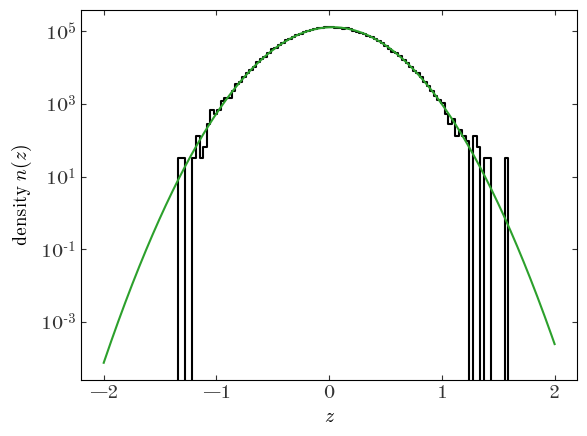

In [14]:
opt_pars = GaussianModel.unpack_pars(res.x)

plt.plot(xc, dens, drawstyle="steps-mid", marker="")

z_grid = np.linspace(z_bins.min(), z_bins.max(), 1024)
plt.plot(
    z_grid,
    np.exp(GaussianModel.ln_density(z_grid, **opt_pars)),
    marker="",
    color="tab:green",
)

plt.yscale("log")

plt.xlabel("$z$")
plt.ylabel("density $n(z)$");

That looks like a pretty good fit! Let's move on to a more flexible example.

### Case 2: Spline model

We will now replace our density model $n(z)$ with a cubic spline representation of the function. We will fix the location of the spline knots by using a hard-set, uniform grid of points in $z$, but the parameters of the model will then be the value of the (log-)density at the locations of the knots. Though there is no jax-ified cubic interpolation built-in to JAX itself (as far as I can tell, it currently only supports linear interpolation), we will use another package — `jax_cosmo` — which provides a jax-aware version of Scipy's `InterpolatedUnivariateSpline`:

In [15]:
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline

Awesome, we now have the main tool we need to enable implementing the spline model, however we have one more mathematical / numerical hurdle to solve: we need to be able to compute the integral of our density model to compute the first term in the Poisson process likelihood
$$
\exp{\left[-\int {\rm d}z \, n(z)\right]}
$$

For generic cubic splines, this integral over all $z$'s is not finite. We therefore have to pick a domain over which to do this integral, and this then slightly changes the meaning of our parameter `ln_N0` to be the number of sources *in the domain we choose*. In practice, if we pick a domain that is large enough and the density function falls off quickly (as it does here), there won't be any practical difference. (But note: if you have a rigid selection region, or if you pick a domain that truncates the data, you have to be more careful than me!) Since our data end around $z\sim \pm 1.5$, we will pick a window of $(-3, 3)$. 

We now need a way of computing the integral of our spline model over this domain. If our parameters were the value of the *density* $N_0$ at the locations of the knots, we could use the `InterpolatedUnivariateSpline.integral()` method directly to compute the integral. However, we use the value of the log-density as parameters, so the integral is not as straightforward. Here, I've implemented a version of [Simpson's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) that takes in the log-function values and returns the log-integral, which is more stable than using other integration tools that would require first exponentiating the density and then taking the log of the estimated integral value on the outside:

In [16]:
def ln_simpson(ln_y, x):
    """
    Evaluate the log of the definite integral of a function evaluated on a
    grid using Simpson's rule
    """

    dx = jnp.diff(x)[0]
    num_points = len(x)
    if num_points // 2 == num_points / 2:
        raise ValueError("Because of laziness, the input size must be odd")

    weights_first = jnp.asarray([1.0])
    weights_mid = jnp.tile(jnp.asarray([4.0, 2.0]), [(num_points - 3) // 2])
    weights_last = jnp.asarray([4.0, 1.0])
    weights = jnp.concatenate([weights_first, weights_mid, weights_last], axis=0)

    return jax.scipy.special.logsumexp(ln_y + jnp.log(weights), axis=-1) + jnp.log(
        dx / 3
    )

With a decision about our integration window and a jax-ified function to compute the value of the log-integral over our spline density function, we can now set up a spline model to fit our toy data:

In [17]:
class GaussianSplineModel(Model):
    knots = jnp.linspace(-3, 3, 11)  # locations of the spline knots
    param_names = {
        "ln_n0": 11,  # the value of the log-density at the knots
    }
    window = (-3, 3)  # integration window for numerical integral of density
    n_integral_pts = 1025  # the number of integration grid points to use

    @staticmethod
    @jax.jit
    def ln_density(x, ln_n0, knots):
        """
        The log-density is just an evaluation of the spline at the input
        """
        ln_dens_spl = InterpolatedUnivariateSpline(knots, ln_n0, k=3)
        return ln_dens_spl(x)

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_likelihood(cls, pars, data):
        """
        Implementation of the log-likelihood for an inhomogeneous Poisson
        process with underlying density (rate) function given by a spline
        """
        ln_dens = cls.ln_density(data["z"], pars["ln_n0"], cls.knots)

        # As mentioned above, to compute the integral over the density, we do
        # the integral numerically using Simpson's rule. For my implementation,
        # we must pass in a grid of points and the log of the function to
        # integrate evaluated at these grid points. The number of grid points is
        # hard-set here, but this should be tuned to meet some accuracy criteria
        V_grid = jnp.linspace(*cls.window, cls.n_integral_pts)
        ln_V = ln_simpson(cls.ln_density(V_grid, pars["ln_n0"], cls.knots), V_grid)
        return -jnp.exp(ln_V) + ln_dens.sum()

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_prior(cls, pars):
        lp = 0.0
        for name, p in pars.items():
            lp += ln_normal(p, 0, 100).sum()
        return lp

With our spline model defined, our integration window set, and our knot locations fixed, we now need to initialize our parameters: the log-density values at the knot locations. We do this by interpolating the estimated density we got from the histogram above at the location of the knots:

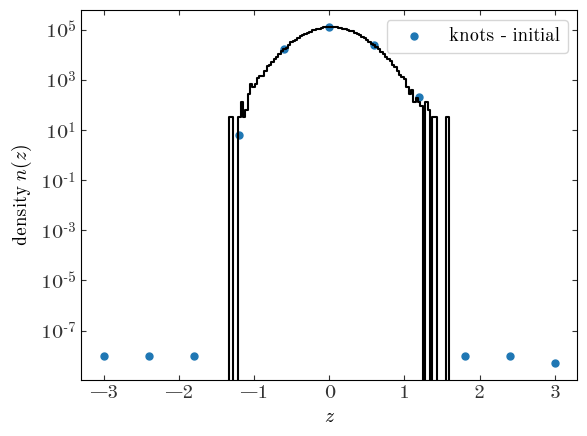

In [18]:
knots = np.linspace(xc.min(), xc.max(), 11)
knots_ln_dens = sci.InterpolatedUnivariateSpline(xc, np.log(dens + 1e-8), k=3)(
    GaussianSplineModel.knots
)

plt.plot(xc, dens, drawstyle="steps-mid", marker="")
plt.scatter(
    GaussianSplineModel.knots,
    np.exp(knots_ln_dens),
    color="tab:blue",
    label="knots - initial",
)
plt.yscale("log")

plt.xlabel("$z$")
plt.ylabel("density $n(z)$")

plt.legend(loc="best")

We can now run the optimizer with our new spline model for the density:

In [19]:
# We add a little bit of random scatter just to make things interesting...
init_pars = {"ln_n0": knots_ln_dens + rng.uniform(0, 0.1, size=len(knots))}
res = sco.minimize(
    jax.value_and_grad(GaussianSplineModel.objective),
    GaussianSplineModel.pack_pars(init_pars),
    args=(len(data["z"]), data),
    jac=True,
    method="l-bfgs-b",
    options=dict(maxiter=1000, maxls=1000),  # I had to increase maxls to succeed
)
res

      fun: -10.260887909516791
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.86425740e-06,  6.56002702e-06, -4.06564716e-05, -1.03612167e-05,
       -1.46661050e-06, -3.35053437e-06,  5.02995779e-06,  6.29047702e-06,
        1.88062757e-05, -6.78824477e-06, -1.25840325e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 37
      nit: 33
     njev: 37
   status: 0
  success: True
        x: array([-18.01096061, -19.45263838, -11.97307253,   2.68899672,
         9.73834031,  11.76439384,  10.06449883,   4.95208879,
        -4.7820572 , -21.05344694, -18.43766302])

Let's plot our optimized spline density function and the value at the knots over our data:

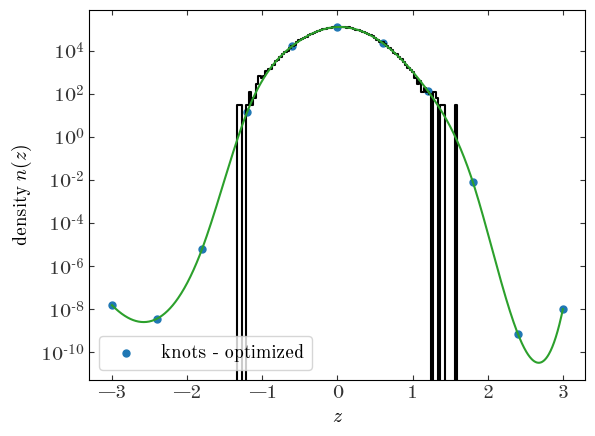

In [20]:
plt.plot(xc, dens, drawstyle="steps-mid", marker="")

opt_pars = GaussianSplineModel.unpack_pars(res.x)

_grid = np.linspace(*GaussianSplineModel.window, 1024)
plt.plot(
    _grid,
    np.exp(
        GaussianSplineModel.ln_density(
            _grid, opt_pars["ln_n0"], GaussianSplineModel.knots
        )
    ),
    marker="",
    color="tab:green",
)
plt.scatter(
    GaussianSplineModel.knots,
    np.exp(opt_pars["ln_n0"]),
    color="tab:blue",
    label="knots - optimized",
)

plt.yscale("log")

plt.xlabel("$z$")
plt.ylabel("density $n(z)$")

plt.legend(loc="best")

Excellent - this also looks like a great fit! Unexpectedly, weird things happen outside of the range where we have data, but here the splines will largely be unconstrained.

Now that we have optimized parameters, and we have a model class with a function that computes the log-posterior probability given data, we can use the optimized parameter values to initialize an MCMC sampling of the parameters. To do this, we will use the [blackjax](https://blackjax-devs.github.io/blackjax/) package to run a Hamiltonian Monte Carlo (HMC) sampler. In detail, we will use the NUTS sampler, and we will use their implementation of a window adaptation method to find good choices for the sampler parameters (step size and inverse mass matrix). This code follows the example code from the "[quick introduction to blackjax](https://blackjax-devs.github.io/blackjax/examples/Introduction.html#nuts)" in the blackjax documentation.

In [21]:
import blackjax

In [22]:
# This is the main loop that does the sampling for us:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

We start by using the blackjax implementation of STAN's window adaptation method to find good choices for the NUTS sampler parameters:

In [23]:
rng_key = jax.random.PRNGKey(42)

fn = jax.tree_util.Partial(GaussianSplineModel.ln_posterior, data=data)
warmup = blackjax.window_adaptation(
    blackjax.nuts,
    fn,
    1000,
)

state, kernel, _ = warmup.run(
    rng_key,
    res.x,
)

With a tuned kernel, we can now run our main inference loop to generate 1000 posterior samples of our parameters:

In [24]:
states = inference_loop(rng_key, kernel, state, 1_000)

Let's see how these look! As a quick check, let's look at a trace plot of a few of the parameters:

Text(0, 0.5, 'parameter value')

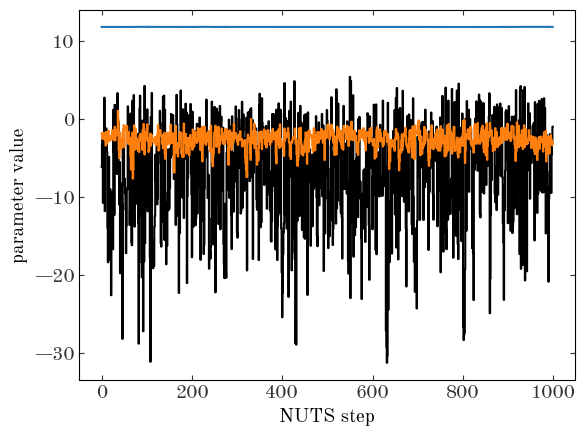

In [25]:
for i in [0, 5, 8]:
    plt.plot(states.position[:, i], marker="", drawstyle="steps-mid")

plt.xlabel("NUTS step")
plt.ylabel("parameter value")

Those look stable! Of course, we should compute some convergence statistics and check on the quality of our samples. But for now, we'll assume that our "by-eye" test is good enough, and proceed :).

For each posterior sample of our parameters, let's compute the implied density function and store these in a big 2D array:

In [26]:
_grid = np.linspace(*GaussianSplineModel.window, 1024)
ln_dens_samples = np.zeros((states.position.shape[0], len(_grid)))
for i, params in enumerate(states.position):
    ln_dens_samples[i] = GaussianSplineModel.ln_density(
        _grid, params, GaussianSplineModel.knots
    )

We can now visualize the 16–84th percentile range of our inferred density function:

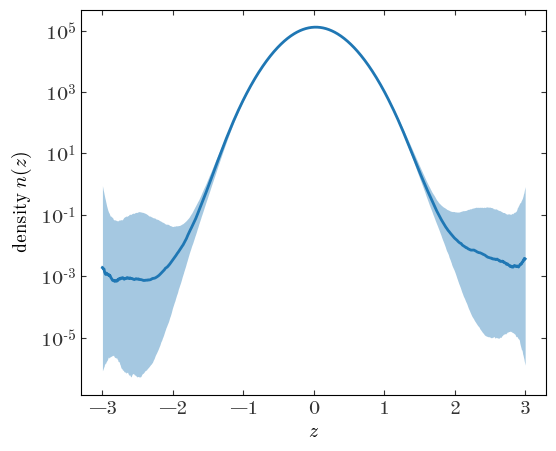

In [27]:
plt.figure(figsize=(6, 5))
plt.fill_between(
    _grid,
    *np.percentile(np.exp(ln_dens_samples), [16, 84], axis=0),
    color="tab:blue",
    alpha=0.4,
    linewidth=0
)
plt.plot(
    _grid,
    np.median(np.exp(ln_dens_samples), axis=0),
    color="tab:blue",
    linewidth=2,
    marker="",
)
plt.yscale("log")

plt.xlabel("$z$")
plt.ylabel("density $n(z)$");

As we might expect, the density function is not well constrained beyond $|z|\gtrsim 2$ or so where we do not have data.

Now that we have a better picture of how to implement these types of flexible spline models with JAX, let's turn to a more complicated science example.

---

## Example: Fitting the density profile and track of a stellar stream

Building off of the 1D spline model we used above, we are now going to move on to a more complicated example motivated by my own research. Here we will try to model the 2D (on sky) density of a [stellar stream](https://en.wikipedia.org/wiki/Stellar_kinematics#Stellar_streams) known as the "GD-1 stream" (named after its discovers [Grillmair & Dionatos](https://ui.adsabs.harvard.edu/abs/2006ApJ...643L..17G/abstract)). There is too much context to cover here, but for the purposes of this demo, assume that we are given a list of sky positions of stars from Gaia and we would like to model the on-sky density of the stream and background to (a) characterize the track of the stream, and (b) identify probable member stars. (The stars we will use have actually been pre-filtered to select distant, low-metallicity, main-sequence stars with proper motions that match the [previously-fit track of the stream](https://ui.adsabs.harvard.edu/abs/2018ApJ...863L..20P/abstract))

Let's start by loading the data, which is included in this repository as a FITS file, so we can load the catalog using [`astropy.table`](https://docs.astropy.org/en/stable/table/index.html):

In [28]:
import astropy.table as at

In [29]:
gd1_tbl = at.Table.read("data/gd1-gaiadr3-blog.fits")

# We will apply one additional selection criteria to limit the number of stars we have to handle:
gd1_tbl = gd1_tbl[gd1_tbl["gd1_phi2"] > -7]
len(gd1_tbl)

2960

The table contains many columns from [Gaia DR3](https://gea.esac.esa.int/archive/), along with some photometry from the Pan-STARS PS1 survey ([data release 2](https://mastweb.stsci.edu/)):

In [30]:
gd1_tbl.colnames

['source_id',
 'ra',
 'dec',
 'parallax',
 'parallax_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'phot_g_mean_mag',
 'phot_g_mean_flux_over_error',
 'phot_bp_mean_mag',
 'phot_bp_mean_flux_over_error',
 'phot_rp_mean_mag',
 'phot_rp_mean_flux_over_error',
 'ruwe',
 'gd1_phi1',
 'gd1_phi2',
 'objID',
 'raMean',
 'decMean',
 'nDetections',
 'ng',
 'nr',
 'ni',
 'nz',
 'ny',
 'gMeanPSFMag',
 'rMeanPSFMag',
 'iMeanPSFMag',
 'zMeanPSFMag',
 'yMeanPSFMag',
 'gMeanPSFMagErr',
 'rMeanPSFMagErr',
 'iMeanPSFMagErr',
 'zMeanPSFMagErr',
 'yMeanPSFMagErr',
 'sep_arcsec']

However, the only two columns we will use here are `gd1_phi1` and `gd1_phi2`, which are the sky positions of stars in a coordinate system in which the GD-1 stream lies approximately along latitude=0 (the coordinate system was defined in Koposov et al. 2010 and is implemented as an `astropy.coordinates` frame in the [gala](https://gala.adrian.pw) package in [gala.coordinates](http://gala.adrian.pw/en/latest/api/gala.coordinates.GD1Koposov10.html)). 

Let's start by making a scatter plot of the sky positions:

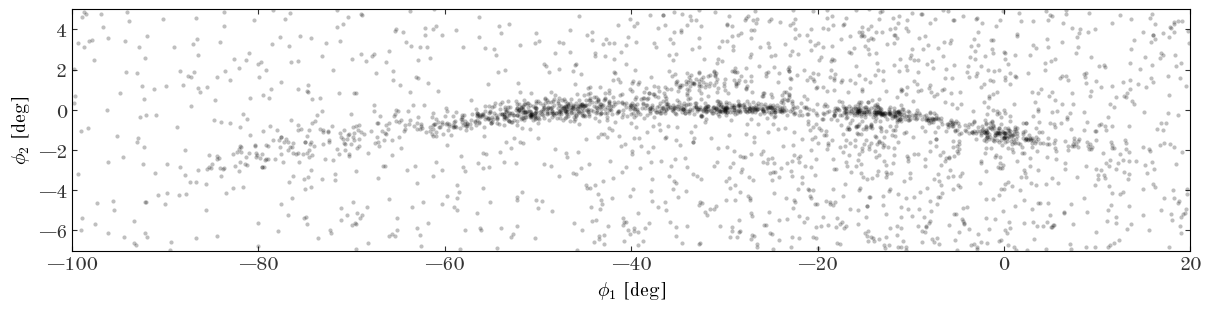

In [31]:
fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)
ax.plot(
    gd1_tbl["gd1_phi1"],
    gd1_tbl["gd1_phi2"],
    marker="o",
    markeredgewidth=0,
    markersize=3.0,
    ls="none",
    alpha=0.25,
)
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]");

### Defining the density model

The curved over-density of stars that arcs from $(\phi_1, \phi_2) \sim (-80, -3)^\circ$ to $(\phi_1, \phi_2) \sim (-40, 0)^\circ$ to $(\phi_1, \phi_2) \sim (0, -2)^\circ$ is the GD-1 stream. This is the density distribution we would like to model using a flexible, spline-based density function. Given the complexity of the stream, we will clearly have to be a bit more baroque in our model specification relative to the previous example. Additionally, there is a non-negligible background density of stars that varies (more smoothly) over the sky region where the stream exists: we will have to simultaneously model this background distribution:
- To represent the background, we will assume that the density is only a function of $\phi_1$ and can be represented as a spline with evenly-spaced knots between $\phi_1 \in [-120, 40]^\circ$. 
- To represent the amplitude of the density of the stream, we will again use a spline as a function of $\phi_1$ with equally-spaced knot locations, now between $\phi_1 \in [-110, 30]^\circ$. Because the density of the stream varies on scales of just a few degrees, we use many more knots to represent the stream density.
- To represent the 2D density distribution of the stream, we use a Gaussian in $\phi_2$ where the mean and standard deviation of the Gaussian are set by spline functions of $\phi_1$. We use the same knot locations for both the mean and standard deviation.

Here we also adopt a "smoothness" prior on the spline values: We assume that the prior on a given $m$ spline value is Gaussian with a mean set by the value of the $m-1$ knot and fixed standard deviations (defined below). For example, for the stream track (or mean $\phi_2$ location $\mu_{\phi_2}$), the prior on the $m$-th mean value is
$$
p(\mu_{\phi_2}^{(m)}) = \mathcal{N}(\mu_{\phi_2}^{(m)} \,|\, \mu_{\phi_2}^{(m-1)}, 0.5^\circ)
$$

This density model is a *mixture model* in that we have two main components of the model: the stream density and the background (bkg) stellar density. What this means in math is that the full density function $n(\phi_1, \phi_2)$ can be expressed as the sum of the two components
$$
n(\phi_1, \phi_2) = n_{\rm stream}(\phi_1, \phi_2) + n_{\rm bkg}(\phi_1, \phi_2)
$$

For numerical stability, we typically work in the log-density instead of the density. Here, that means:
$$
\ln n(\phi_1, \phi_2) = \ln\left[n_{\rm stream}(\phi_1, \phi_2) + n_{\rm bkg}(\phi_1, \phi_2)\right]
$$

But because of the sum, you might think we are stuck adding (potentially) large numbers before taking the log. Luckily, there is a trick for handling cases like this that appears in many different statistics and data science applications known as ["logsumexp"](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/), which you will see me use below when combining the individual densities.

As a final point, as was the case with our 1D spline model from Example 1, the integral over the full 2D density function (including the background model and stream model components) is not easily expressible in closed form, but we can use the same numerical integration trick we used above for this model.

The model is more complex than the 1D models, but I will describe each element of the model below using comments:

In [32]:
class StreamModel(Model):
    # The phi_1 locations of the knots used for representing the background density:
    bkg_knots = jnp.linspace(-120, 40, 7)

    # The phi_1 locations of the knots used for representing the density along the stream,
    # and for representing the mean and standard deviation of the stream density in the
    # phi_2 direction:
    ln_n0_knots = jnp.linspace(-110, 30, 31)
    phi2_knots = jnp.linspace(-110, 30, 17)

    param_names = {
        "ln_n0": len(ln_n0_knots),  # The value of the stream density at the knots
        "mean_phi2": len(phi2_knots),  # The mean phi_2 location of the stream
        "ln_std_phi2": len(phi2_knots),  # The stddev in phi_2 of the stream
        "ln_n0_bkg": len(bkg_knots),  # The value of the background density
    }

    # Here we pre-define the grids we will use to perform the numerical integration of
    # the density over our data window phi_1 in (-100, 20) and phi_2 in (-7, 5).
    # A quick note that because I use Simpson's rule for integration, we have to choose
    # a fixed grid to perform the integral on. I had initially chosen a step size of
    # 0.2º but ran into many issues with the optimizer not being able to find a
    # successful solution. I increased the resolution of the integration grid and it
    # seems to work for me, but a caveat here is that there will be some sensitivity to
    # the choice of integration grid. We could use an adaptive method, but I didn't find
    # a good log implementation like we have here for Simpson's rule.
    integ_grid_phi1_1d = jnp.arange(-100, 20 + 1e-3, 0.1)
    integ_grid_phi2_1d = jnp.arange(-7, 5 + 1e-3, 0.1)
    integ_grid_phi1, integ_grid_phi2 = jnp.meshgrid(
        integ_grid_phi1_1d, integ_grid_phi2_1d
    )

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_density_stream(cls, phi1, phi2, ln_n0, mean_phi2, ln_std_phi2):
        """
        This function evaluates the log-density of the stream component of the model
        """
        # As in the 1D example above, we construct interpolating splines given the
        # pre-determined knot locations, with values given as input (i.e. parameters)
        ln_n0_spl = InterpolatedUnivariateSpline(cls.ln_n0_knots, ln_n0, k=3)
        mean_phi2_spl = InterpolatedUnivariateSpline(cls.phi2_knots, mean_phi2, k=3)
        ln_std_phi2_spl = InterpolatedUnivariateSpline(cls.phi2_knots, ln_std_phi2, k=3)

        # We evaluate the splines at the locations of the input data phi1, phi2:
        ln_dens = ln_n0_spl(phi1) + ln_normal(
            phi2, mean_phi2_spl(phi1), jnp.exp(2 * ln_std_phi2_spl(phi1))
        )

        return ln_dens

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_density_bkg(cls, phi1, phi2, ln_n0_bkg):
        """
        This function evaluates the log-density of the background stellar density
        """
        ln_n0_spl = InterpolatedUnivariateSpline(cls.bkg_knots, ln_n0_bkg, k=3)
        return ln_n0_spl(phi1)

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_density(cls, phi1, phi2, ln_n0, mean_phi2, ln_std_phi2, ln_n0_bkg):
        """
        This evaluates the total model density
        """
        ln_dens1 = cls.ln_density_stream(phi1, phi2, ln_n0, mean_phi2, ln_std_phi2)
        ln_dens2 = cls.ln_density_bkg(
            phi1,
            phi2,
            ln_n0_bkg,
        )

        # Note: this is the "logsumexp" trick mentioned above:
        ln_dens = jnp.logaddexp(ln_dens1, ln_dens2)
        return ln_dens

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_likelihood(cls, pars, data):
        """
        Implementation of the log-likelihood for an inhomogeneous Poisson
        process with underlying density (rate) function
        """
        ln_dens = cls.ln_density(
            data["phi1"],
            data["phi2"],
            pars["ln_n0"],
            pars["mean_phi2"],
            pars["ln_std_phi2"],
            pars["ln_n0_bkg"],
        )

        # Here is where we perform the log-integral over n(phi1, phi2) using Simpson's
        # rule. We evauate the log-density function on our pre-defined 2D grid, and use
        # the ln_simpson() function defined above twice to compute the integral:
        ln_dens_grid = cls.ln_density(cls.integ_grid_phi1, cls.integ_grid_phi2, **pars)
        ln_V = ln_simpson(
            ln_simpson(ln_dens_grid, cls.integ_grid_phi1_1d), cls.integ_grid_phi2_1d
        )
        return -jnp.exp(ln_V) + ln_dens.sum()

    @classmethod
    @partial(jax.jit, static_argnums=(0,))
    def ln_prior(cls, pars):
        lp = 0.0

        # The loops below implement the "smoothness" priors on the splines that was
        # mentioned above. The standard deviation values were picked arbitrarily to
        # enforce some smoothness, but to not be too aggressive:
        for i in range(1, len(cls.ln_n0_knots)):
            lp += ln_normal(pars["ln_n0"][i], pars["ln_n0"][i - 1], 1)

        for i in range(1, len(cls.phi2_knots)):
            lp += ln_normal(pars["mean_phi2"][i], pars["mean_phi2"][i - 1], 1)

        for i in range(1, len(cls.phi2_knots)):
            lp += ln_normal(pars["ln_std_phi2"][i], pars["ln_std_phi2"][i - 1], 1)

        return lp

In [33]:
StreamModel.integ_grid_phi1.shape, StreamModel.integ_grid_phi2.shape

((121, 1201), (121, 1201))

Now that we have our density model class defined, let's start by computing the density on a 2D grid with some randomly chosen parameter values (i.e. spline knot values). To visualize the density, we will use the 2D integration grid we defined above as `StreamModel.integ_grid_phi1` and `StreamModel.integ_grid_phi2` for $\phi_1$ and $\phi_2$ values, respectively:

Text(0.5, 0, '$\\phi_1$ [deg]')

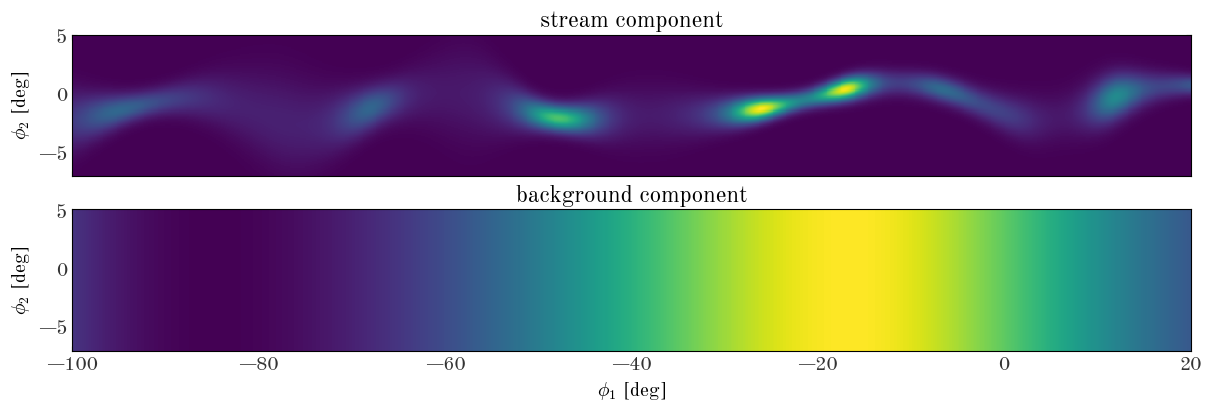

In [34]:
rng = np.random.default_rng(seed=666)

# Random values for the stream splines:
ln_n0 = rng.uniform(-1, 1, size=len(StreamModel.ln_n0_knots))
mean_phi2 = rng.uniform(-3, 2, size=len(StreamModel.phi2_knots))
ln_std_phi2 = rng.uniform(-1, 1, size=len(StreamModel.phi2_knots))
ln_dens = StreamModel.ln_density_stream(
    StreamModel.integ_grid_phi1,
    StreamModel.integ_grid_phi2,
    ln_n0,
    mean_phi2,
    ln_std_phi2,
)

# And the background density:
ln_n0_bkg = rng.uniform(-1, 1, size=len(StreamModel.bkg_knots))
ln_dens_bkg = StreamModel.ln_density_bkg(
    StreamModel.integ_grid_phi1, StreamModel.integ_grid_phi2, ln_n0_bkg
)

fig, axes = plt.subplots(
    2, 1, figsize=(12, 4), sharex=True, sharey=True, constrained_layout=True
)
axes[0].pcolormesh(
    StreamModel.integ_grid_phi1, StreamModel.integ_grid_phi2, np.exp(ln_dens)
)
axes[0].set_title("stream component")
axes[1].pcolormesh(
    StreamModel.integ_grid_phi1, StreamModel.integ_grid_phi2, np.exp(ln_dens_bkg)
)
axes[1].set_title("background component")

for ax in axes:
    ax.set_ylabel(r"$\phi_2$ [deg]")
axes[1].set_xlabel(r"$\phi_1$ [deg]")

### Initializing the density model parameters

In many real-world optimization problems, especially those with many parameters like we have here, a good initialization is often important for success (or at least speed) of the optimizer. We could try initializing the stream model and background with random settings of the parameter (as we visualized above), but it's usually worth spending a bit of time estimating better initial guesses for your parameters. 

We will therefore spend a few cells below manipulating the data to estimate the rough on-sky track and density of the stream, and the density of the stellar background.

In [35]:
from scipy.ndimage import gaussian_filter1d

There are many ways we could do this, but in the cell below I bin the data coarsely in $\phi_1$ and fine in $\phi_2$, smooth the data, and find the location of the peak in $\phi_2$ in the coarse $\phi_1$ bins. I then convert the number counts to density so we can extract the rough track of the stream in $\phi_1, \phi_2$ along with a density estimate at each of these locations.

Text(0.5, 0, '$\\phi_1$')

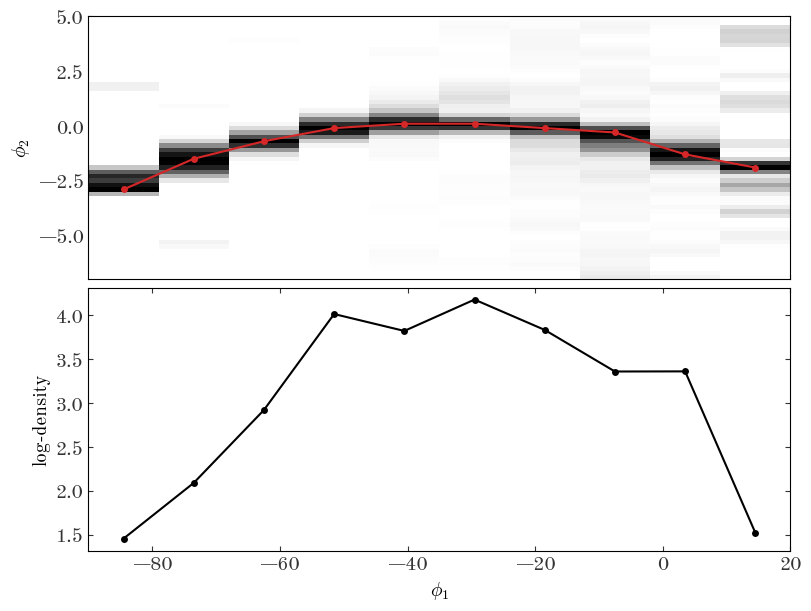

In [36]:
H, xe, ye = np.histogram2d(
    gd1_tbl["gd1_phi1"],
    gd1_tbl["gd1_phi2"],
    bins=(np.linspace(-90, 20 + 1e-3, 11), np.arange(-7, 5 + 1e-3, 0.2)),
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

H = gaussian_filter1d(H, sigma=1)
H -= np.mean(H[:, (yc < -5) | (yc > 3)])

H /= (xe[1] - xe[0]) / 12
H_density = H.copy()

peak_idx = H.argmax(axis=1)
H /= H[np.arange(H.shape[0]), peak_idx][:, None]
H_ln_density = np.log(H_density[np.arange(H.shape[0]), peak_idx])


fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
cs = axes[0].pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
axes[0].plot(xc, yc[peak_idx], color="tab:red")
axes[0].set_ylabel(r"$\phi_2$")
axes[1].plot(xc, H_ln_density)
axes[1].set_ylabel(r"log-density")
axes[1].set_xlabel(r"$\phi_1$")

We now have to interpolate these estimates to the location of our spline knots to set the initial parameters of our stream model:

In [37]:
init_ln_n0 = sci.InterpolatedUnivariateSpline(xc, H_ln_density)(StreamModel.ln_n0_knots)

init_mean_phi2 = sci.InterpolatedUnivariateSpline(xc, yc[peak_idx])(
    StreamModel.phi2_knots
)

Next we will handle the stellar background. Here, we select stars above and below the stream (in $\phi_2$), estimate the 1D density of the background using a histogram, and smooth the estimates.

Text(0.5, 0, '$\\phi_1$')

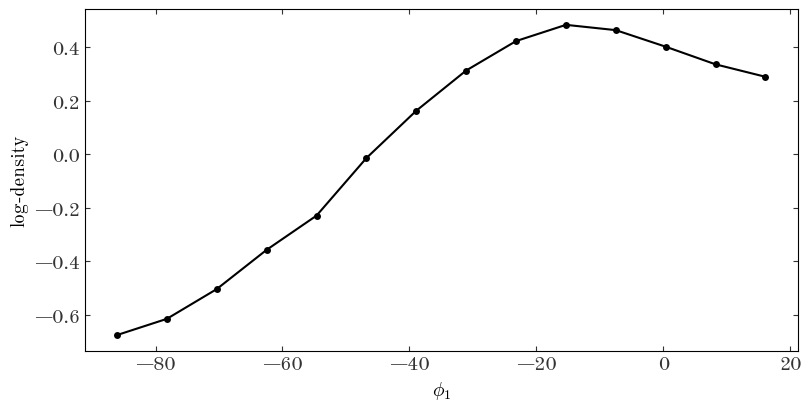

In [38]:
_mask = (gd1_tbl["gd1_phi2"] > 3) | (gd1_tbl["gd1_phi2"] < -5)
H, xe = np.histogram(gd1_tbl["gd1_phi1"][_mask], bins=np.linspace(-90, 20 + 1e-3, 15))
xc = 0.5 * (xe[:-1] + xe[1:])

dx = xe[1] - xe[0]
H = np.log(gaussian_filter1d(H, sigma=2) / dx / 4)

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
ax.plot(xc, H)
ax.set_ylabel(r"log-density")
ax.set_xlabel(r"$\phi_1$")

We again have to interpolate these values to the location of our model spline knots:

In [39]:
init_ln_n0_bkg = sci.InterpolatedUnivariateSpline(xc, H)(StreamModel.bkg_knots)

Now we can package up our initial parameter estimates and try evaluating the `StreamModel.ln_density()` with this initial guess to see how well we did at estimating the properties of the stream.

In [40]:
init_pars = {
    "ln_n0": init_ln_n0,
    "mean_phi2": init_mean_phi2,
    "ln_std_phi2": np.full_like(init_mean_phi2, -1),
    "ln_n0_bkg": init_ln_n0_bkg,
}
ln_dens_init = StreamModel.ln_density(
    StreamModel.integ_grid_phi1, StreamModel.integ_grid_phi2, **init_pars
)

We plot the initial guess of the full density distribution and over-plot the positions of the stars in our sample to see how well we did at setting initial guesses:

Text(0, 0.5, '$\\phi_2$')

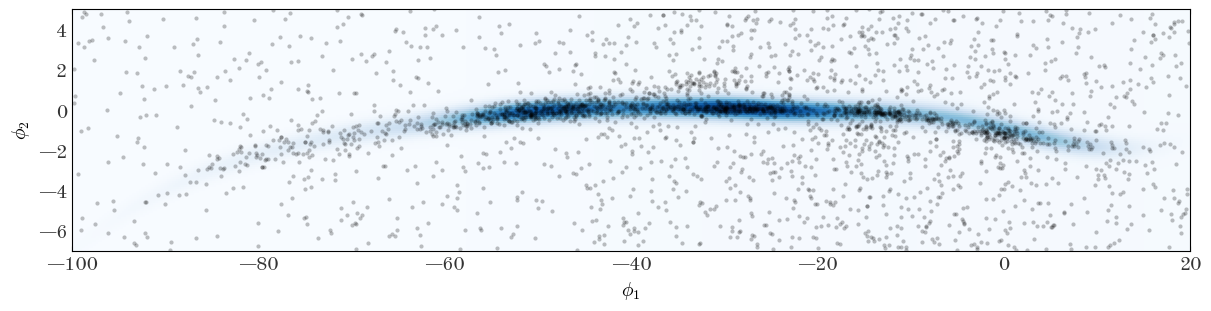

In [41]:
fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)

ax.plot(
    gd1_tbl["gd1_phi1"],
    gd1_tbl["gd1_phi2"],
    marker="o",
    markeredgewidth=0,
    markersize=3.0,
    ls="none",
    alpha=0.25,
)
ax.pcolormesh(
    StreamModel.integ_grid_phi1,
    StreamModel.integ_grid_phi2,
    np.exp(ln_dens_init),
    cmap="Blues",
)
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

That already looks pretty good, but clearly there are places where we hope the optimizer will tune the model parameters to align the track and width of the stream to the data we have. Let's get set up to run the optimizer from these initial parameter estimates:

In [42]:
data = {
    "phi1": gd1_tbl["gd1_phi1"].astype(np.float64),
    "phi2": gd1_tbl["gd1_phi2"].astype(np.float64),
}
init_p = StreamModel.pack_pars(init_pars)

This is not necessary, but I always like to evaluate the objective function I want to optimize at the initial parameter values to make sure there are no nan or inf values that will cause the optimizer to immediately fail:

In [43]:
StreamModel.objective(init_p, N=len(data["phi1"]), data=data)

DeviceArray(-0.05543877, dtype=float64)

Good, that looks fine! Let's fire up the optimizer. We will again use the L-BFGS-B method:

In [44]:
res = sco.minimize(
    jax.value_and_grad(StreamModel.objective),
    StreamModel.pack_pars(init_pars),
    args=(len(data["phi1"]), data),
    jac=True,
    method="l-bfgs-b",
    options=dict(maxiter=100_000, maxls=1000),
)
res

      fun: -0.4172804414762403
 hess_inv: <72x72 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.71418475e-07,  1.65857911e-07,  1.99453381e-07, -2.05370143e-06,
       -1.70964779e-06, -4.62670967e-06,  1.68103189e-06,  2.09021076e-06,
       -1.10096842e-06,  2.27286148e-06, -1.52102203e-06, -1.37678490e-06,
       -2.28720309e-06, -2.26237554e-06, -1.30669594e-07, -3.37215730e-06,
       -1.02103330e-06,  8.87957954e-07,  2.43060947e-06,  4.48877098e-06,
        2.33454660e-06,  1.11753802e-06,  9.77205135e-07, -6.95522218e-07,
        1.15479706e-06, -1.69470906e-06,  1.78318820e-06, -1.94111769e-07,
       -5.52840315e-07, -7.36288750e-07, -8.92639157e-07,  1.55186650e-06,
       -1.59999460e-06, -3.26062519e-07,  3.79777447e-07,  3.28915248e-06,
       -7.19254555e-07, -3.63050574e-06, -1.34650105e-05, -1.33010540e-06,
        3.07614063e-05,  1.18970084e-05,  1.65802843e-05,  4.66520356e-06,
       -1.04483424e-06,  5.07504938e-07, -2.62358590e-06,  1.97680049e-07,


It looks like that succeeded! Let's look at the optimized parameters:

In [45]:
opt_pars = StreamModel.unpack_pars(res.x)
opt_pars

{'ln_n0': DeviceArray([-1.29724792, -1.29012651, -1.32220017, -1.01112565,
              -0.4372693 ,  0.58312065,  1.56485491,  1.84623316,
               1.86679529,  1.75244974,  1.79167502,  2.39936208,
               2.96517374,  3.28641774,  3.13259102,  2.63325926,
               2.72104495,  2.89475705,  2.89169773,  1.78894259,
               2.6488234 ,  3.05108255,  2.03688664,  2.74065293,
               2.74767283,  1.03251669,  0.73350755, -0.19425672,
              -0.36811195, -0.38745796, -0.38802526], dtype=float64),
 'ln_n0_bkg': DeviceArray([-2.76395382, -0.72947985, -0.56382768,  0.23704327,
               0.85720292,  0.13801779,  1.7967009 ], dtype=float64),
 'ln_std_phi2': DeviceArray([-1.83413212, -1.86183605, -1.61951924, -0.98992293,
              -0.53122539, -0.83928341, -1.24429333, -1.24835943,
              -1.08013281, -1.86097141, -1.66590174, -1.82412536,
              -1.64303541, -1.32500325, -1.95722173, -1.62772084,
              -1.67305163], dty

Again, it looks like there are no NaN or inf values, so that's good. Let's now compare the optimized parameters to our initial guesses:

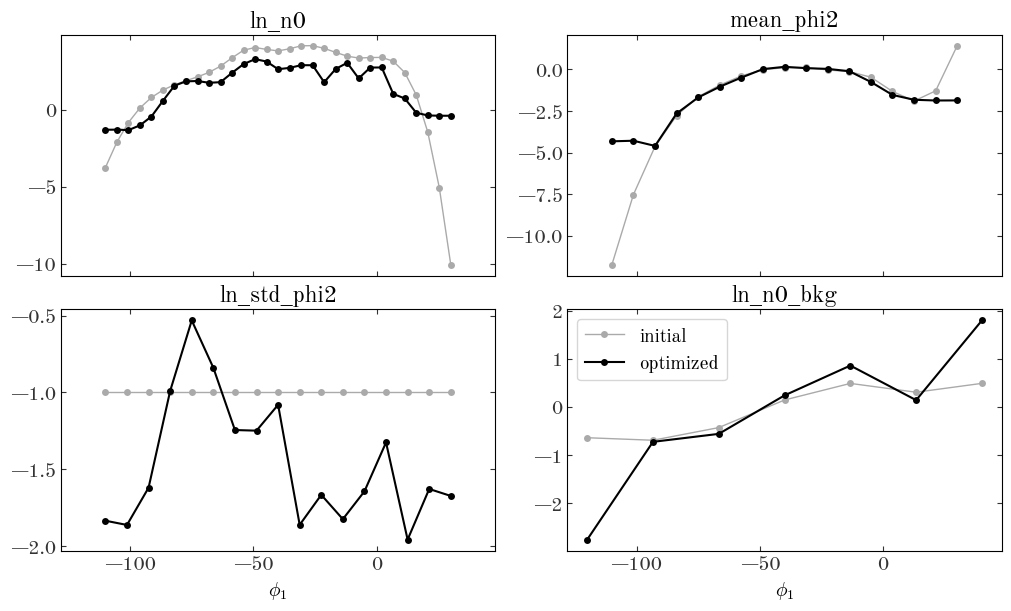

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
for ax, knots, name in zip(
    axes.flat,
    [
        StreamModel.ln_n0_knots,
        StreamModel.phi2_knots,
        StreamModel.phi2_knots,
        StreamModel.bkg_knots,
    ],
    ["ln_n0", "mean_phi2", "ln_std_phi2", "ln_n0_bkg"],
):
    ax.plot(knots, init_pars[name], label="initial", color="#aaaaaa", linewidth=1)
    ax.plot(knots, opt_pars[name], label="optimized", color="k")
    ax.set_title(name)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

ax.legend(loc="best", fontsize=14)

We can also look at the 2D density computed from our optimized parameters and visually compare to the data:

In [47]:
ln_dens_opt = StreamModel.ln_density(
    StreamModel.integ_grid_phi1, StreamModel.integ_grid_phi2, **opt_pars
)

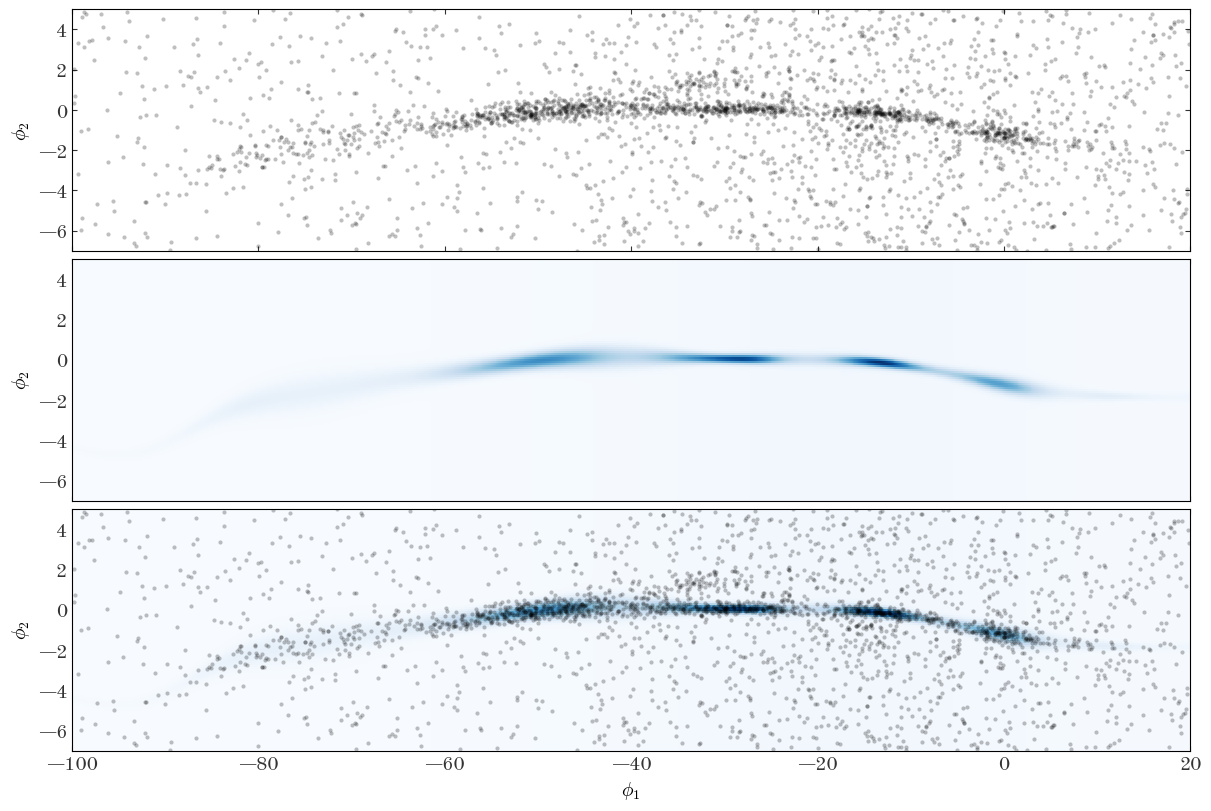

In [48]:
fig, axes = plt.subplots(
    3, 1, figsize=(12, 8), sharex=True, sharey=True, constrained_layout=True
)

for ax in [axes[0], axes[2]]:
    ax.plot(
        gd1_tbl["gd1_phi1"],
        gd1_tbl["gd1_phi2"],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )

ax = axes[1]
ax.pcolormesh(
    StreamModel.integ_grid_phi1,
    StreamModel.integ_grid_phi2,
    np.exp(ln_dens_opt),
    cmap="Blues",
)

ax = axes[2]
ax.pcolormesh(
    StreamModel.integ_grid_phi1,
    StreamModel.integ_grid_phi2,
    np.exp(ln_dens_opt),
    cmap="Blues",
)

ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

axes[-1].set_xlabel(r"$\phi_1$")
for ax in axes:
    ax.set_ylabel(r"$\phi_2$")

This looks like a pretty good representation of the stream density and track, so I would call this a success! With the optimized parameters in hand, we could then run a sampler (like the HMC/NUTS sampler we used above) to generate posterior samples over our parameters and assess uncertainty in the model, or compute membership probabilities of belonging to the stream for the stars in this field. In a real application, we may also want to assess our choices by trying a few different settings for the number of spline knots for the different components of the model.

## Recap

This tutorial demonstrates how to use flexible, spline-based models in density functions with [JAX](https://jax.readthedocs.io/), which provides automatic calculation of gradients through our models and enables fast optimization and MCMC sampling methods even in cases like the above where the number of parameters is large.

If you have any comments or questions about this tutorial, please [open an issue on the GitHub repository for this post](https://github.com/adrn-blog/post--flexible-density-model-jax/issues). Thanks for reading!